Build PSF fitting library

In [ ]:
# %%capture will hide the output
%cd /content
!rm -rf /content/fastpsf
!git clone https://gitlab.com/jcnossen/fastpsf.git
%cd /content/fastpsf
!cmake .
!make clean & make
%cd /content/fastpsf/python/
!python setup.py develop

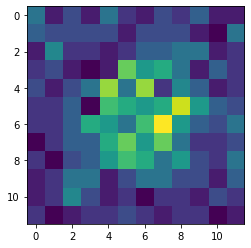

In [3]:
# Check that fastpsf + CUDA is running ok by evaluating a 2D Gaussian..
from fastpsf import Context, GaussianPSFMethods
import matplotlib.pyplot as plt

with Context() as ctx:
  roisize =12
  psf = GaussianPSFMethods(ctx).CreatePSF_XYIBg(roisize, sigma = 2, cuda=True)
  plt.imshow(psf.GenerateSample([[roisize/2,roisize/2,200,2]])[0])



Build DME drift estimation library

In [4]:
# %%capture will hide the output
%%capture
%cd /content
!git clone https://gitlab.com/jcnossen/dme.git
%cd /content/dme
!cmake .
!make clean & make
!python setup.py develop

Clone simflux code

In [ ]:
# %%capture will hide the output
#%%capture
%cd /content
!rm -rf /content/simflux2
!git clone https://gitlab.com/qnano/simflux2.git
%cd /content/simflux2
!python setup.py develop

## Run simflux simulation

pos=1.001. step=0.007: : 101it [00:00, 821.56it/s]
pos=1.001. step=0.002: : 273it [00:00, 941.23it/s]
pos=1.001. step=0.002: : 244it [00:00, 639.75it/s]
pos=1.001. step=0.008: : 71it [00:00, 277.91it/s]
pos=1.001. step=0.003: : 180it [00:00, 893.12it/s]
pos=1.001. step=0.002: : 215it [00:00, 526.71it/s]
pos=1.023. step=0.077: : 149it [00:00, 476.43it/s]
pos=1.003. step=0.004: : 141it [00:00, 476.17it/s]
pos=1.001. step=0.003: : 224it [00:00, 1051.49it/s]
pos=1.000. step=0.003: : 156it [00:00, 320.12it/s]


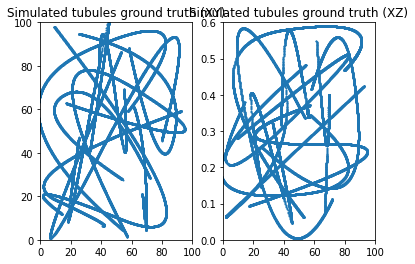

In [6]:
import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import smlmtorch.simflux.pattern_estimator as pe
import numpy as np
from smlmtorch.simflux.simulate import angles_to_mod
import matplotlib.pyplot as plt
from smlmtorch.ui.array_view import array_view
from smlmtorch.multipart_tiff  import MultipartTiffSaver
from smlmtorch import Dataset

from smlmtorch.simflux.simulate import simulate
from smlmtorch.simflux import SFLocalizer

import tqdm
from fastpsf import Context, GaussianPSFMethods, CSplineMethods, CSplineCalibration

from smlmtorch.util.generate_tubules import generate_microtubule_points
from smlmtorch.simflux.localizer_report import LocalizationReporter
from smlmtorch.simflux.pattern_estimator import ModulationPattern
from smlmtorch import struct


sim_roisize = 10  # simulation roisize
roisize = 10 # localization roisize

psf_calib = [1.8,1.8]
psf_label= 'gauss1.8px'

np.random.seed(0)

W = 100
Zrange = [0.1, 0.7]
pts = generate_microtubule_points(W, depth=Zrange[1]-Zrange[0], 
                                        numtubules = 10, 
                                        linedensity=20, margin=0)

on_fraction = 0.001
avg_on_time = 6
nframes = 5000
intensity = 1000

pts[:,2] += Zrange[0]

background = 4 # approximately dna paint background on our dmd setup
path = f'simulated/{psf_label}/sim_gauss2D_tubules_bg{background}_I{intensity}.tif'


pixelsize = 100
pattern_frames = np.array([[0,2,4], [1,3,5]])
mod = angles_to_mod([200, 200], pixelsize, [1, 91], 0.95, pattern_frames)

mp_gt = ModulationPattern(pattern_frames, mod)

cfg = struct(
   psf_calib= psf_calib,
   roisize=roisize,
   detection_threshold=2,
   pattern_frames= pattern_frames,
   gain= 1,
   offset= 0,
   pixelsize= pixelsize,
   zrange= Zrange, # [0.2, 0.6]# [-0.3, 1.3]
   debug_mode=False,
   psf_sigma_binsize = None,
   result_dir='results2'
)



In [7]:

#%% Simulation

psf_calib_sim = psf_calib
with Context() as ctx:
    psf = GaussianPSFMethods(ctx).CreatePSF_XYIBg(sim_roisize, psf_calib_sim, cuda=True)
    simulate(path, mp_gt, psf, 
         pts[:,:2], numframes=nframes, intensity=intensity, width=W, 
         bg=background, avg_on_time=avg_on_time, on_fraction=on_fraction)



  0%|          | 0/5000 [00:00<?, ?it/s]

p_off=0.999, k_on=0.000, k_off=0.042


#spots=203917: 100%|██████████| 5000/5000 [00:55<00:00, 90.35it/s]


Reading sim_gauss2D_tubules_bg4_I1000.tif: 100%|██████████| 1/1 [00:00<00:00, 262.87it/s]


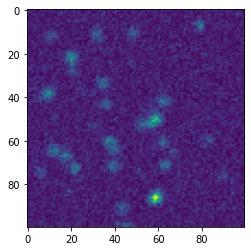

In [9]:
from smlmtorch.multipart_tiff import tiff_read_all
frame0 = tiff_read_all(path, 0, maxframes=1)[0]
plt.imshow(frame0)


### Perform regular SMLM on summed frames, and estimate intensities of each localization for each 6 different pattern exposures

Processing simulated/gauss1.8px/sim_gauss2D_tubules_bg4_I1000.tif with 5000 frames
moving_window=True


100%|█████████▉| 29970/30000 [00:13<00:00, 2225.87it/s]


Num ROIs: 137632


Fitting with known PSF sigma: 100%|██████████| 137632/137632 [00:02<00:00, 57008.45it/s]


Removing 0 localizations with NaN
Remaining localizations: 137407/137632
Chi-sq filtered: 135186/137407
Saving Picasso-compatible hdf5 to simulated/gauss1.8px/results2/sim_gauss2D_tubules_bg4_I1000/smlm.hdf5
Median intensity: 838. Bg: 24.95 Median CRLB: X=13.1 nm Y=13.1 nm. (0.13, 0.13 px)
numrois: 137632. #summed_fits: 137632


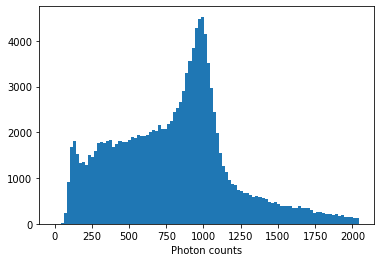

In [10]:

#%%
cfg['psf_calib'] = psf_calib
cfg['roisize'] = roisize
sfloc = SFLocalizer(path, **cfg, device='cuda:0')

sfloc.detect_spots(ignore_cache=False, moving_window=True)
smlm_ds = sfloc.fit_smlm(max_crlb_xy=None, ignore_cache=False)
print(f"numrois: {sfloc.numrois}. #summed_fits: {sfloc.summed_fits.shape[0]}")



Angle: 1.00, Pitch: 199.90 nm
Angle: 91.01, Pitch: 199.95 nm


Generating modulation pattern plots: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]


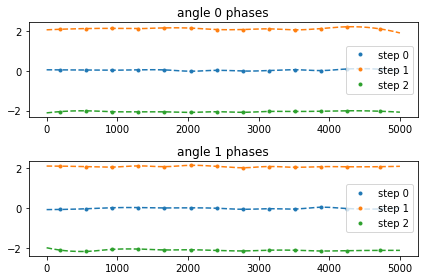

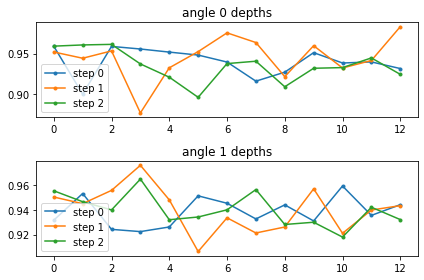

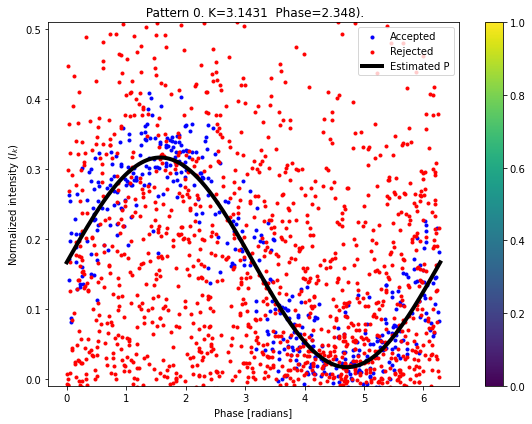

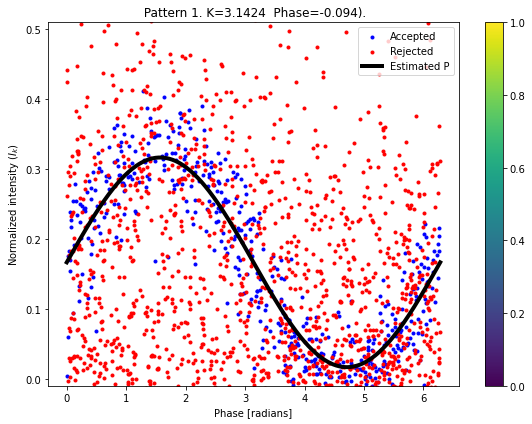

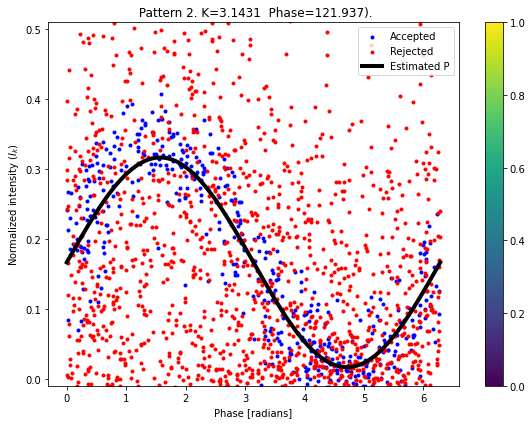

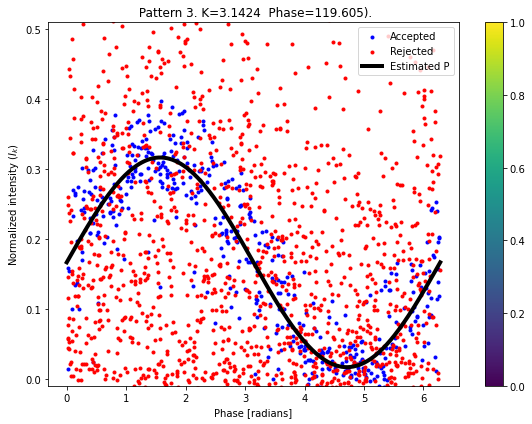

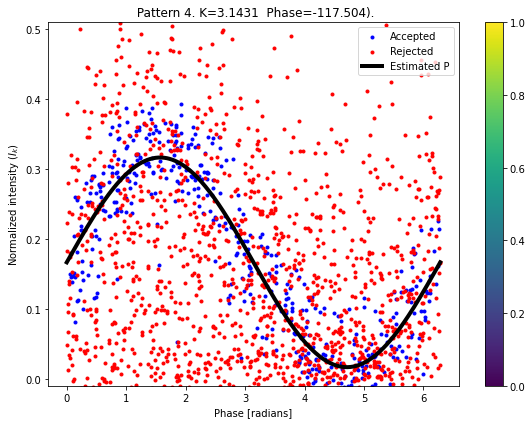

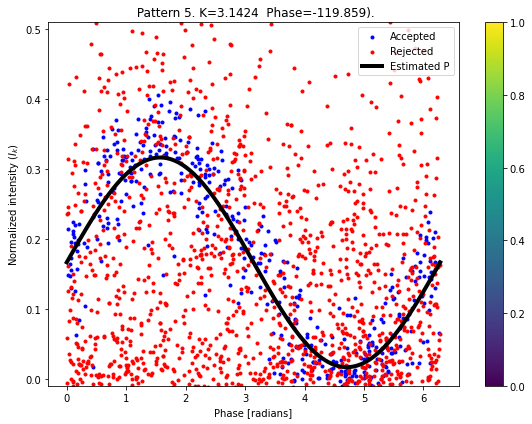

In [11]:

if nframes > 600 and W>40:
    mp_est = sfloc.estimate_angles(pitch_minmax_nm=[100,240])
    mp_est = sfloc.estimate_phases(mp_est, frame_binsize=10000, 
                                   accept_percentile=40, iterations=10, verbose=False)
    
else:
    mp_est=mp_gt

mp_est.mod['depth'] = 0.9
lr = LocalizationReporter(sfloc.sum_ds, sfloc.result_dir, mp_est)
lr.draw_patterns(2, me_threshold=0.1)



100%|██████████| 30965/30965 [00:00<00:00, 57064.80it/s]


Saving Picasso-compatible hdf5 to simulated/gauss1.8px/results2/sim_gauss2D_tubules_bg4_I1000/sf.hdf5


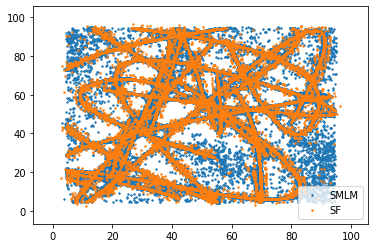

In [12]:
# Filter by modulation error
me = mp_est.mod_error(smlm_ds)
me_sel = me < 0.1

sf_ds = sfloc.fit_simflux(mp_est, smlm_ds[me_sel], iterations=50, lambda_=500, normalizeWeights=True, ignore_cache=False)
lr.scatterplot([ sfloc.sum_ds, sf_ds ], connected=False, labels=['SMLM', 'SF'], limits=None, s=2)



Keeping 102355/135186 spots
Elapsed time: 0.9 s. FRC=54.64 nm
Keeping 29612/29697 spots
Elapsed time: 1.3 s. FRC=25.19 nm


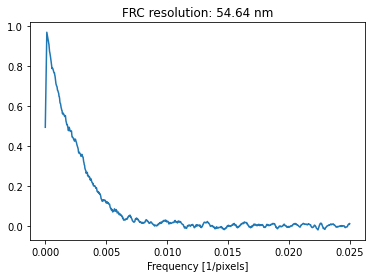

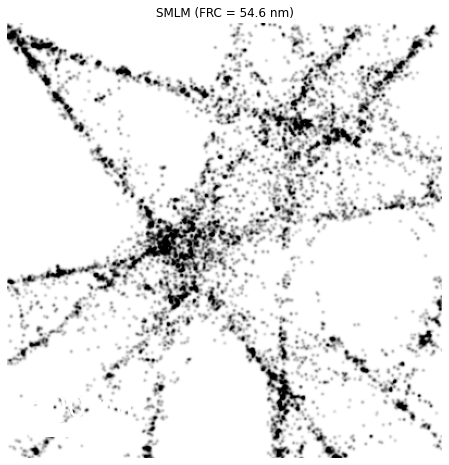

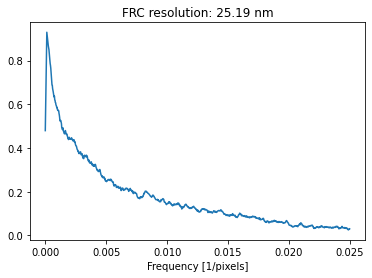

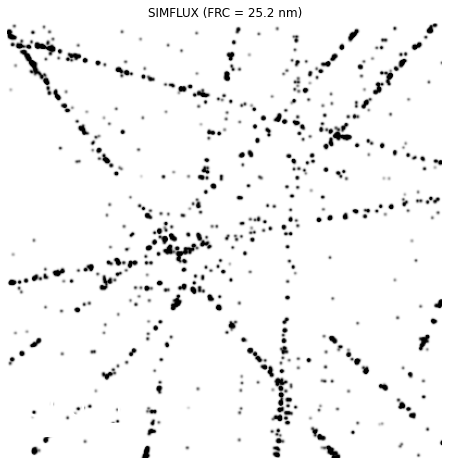

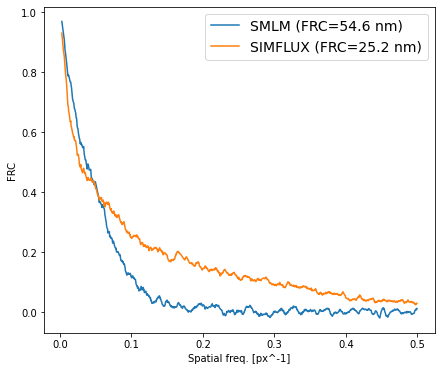

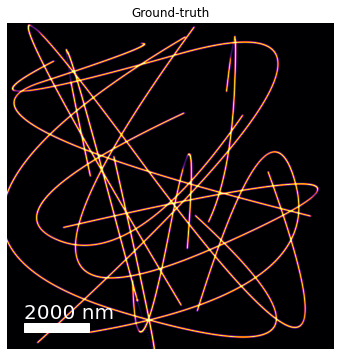

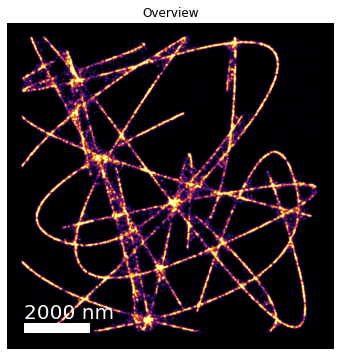

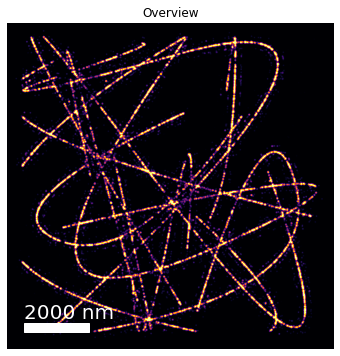

In [13]:
roi=(43,45),(63,65)
figsize=(8,8)
zoom = 20

datasets=[
    ('smlm', 'SMLM'),
    ('sf', 'SIMFLUX'),
    ]

frc_curves = []
frc_val = []

for fn,label in datasets:
    ds = Dataset.load(sfloc.result_dir + f'{fn}.hdf5')
    ds['pixelsize'] = pixelsize
    
    ds.crlb_filter(0.2)

    zoom=20    
    ds_frc, frc_curve = ds.frc(display=True, zoom=zoom, smooth=10)
    fig,ax=plt.subplots(figsize=figsize)
    ds.crop(*roi, silent=True).renderFigure(axes=ax,title=f'{label} (FRC = {ds_frc:.1f} nm)', 
                                           zoom=zoom, clip_percentile=98, scalebar_nm=500,
                                           scalebar_fontsize=30, cmap='gray_r')
    
    frc_curves.append(frc_curve)
    frc_val.append(ds_frc)
    
    plt.savefig(sfloc.result_dir + f"render-{fn}.png")
    plt.savefig(sfloc.result_dir + f"render-{fn}.svg")

freq = np.fft.fftfreq(zoom*W)
freq = freq[:W*zoom//2]

fig,ax=plt.subplots(figsize=(7,6))
for i in [0,1]:
    frc = frc_curves[i]
    frc = frc[5:W*zoom//2]
    plt.plot(freq[5:],  frc , label=f'{datasets[i][1]} (FRC={frc_val[i]:.1f} nm)')
plt.legend(fontsize=14)
plt.ylabel('FRC')
plt.xlabel('Spatial freq. [px^-1]')
plt.savefig(sfloc.result_dir+'frc-compare.svg')




## Render the different datasets (ground truth / smlm / sf)

In [ ]:


#%%
figsize=(6,6)
zoom = 6
render_args = dict(clip_percentile=97, 
                   pixelsize=pixelsize, 
                   scalebar_nm=2000, 
                   scalebar_fontsize=20)

# render ground truth

ds_gt = Dataset(len(pts), 2,(W,W), pixelsize=pixelsize)
ds_gt.pos[:,:2] = pts[:,:2]
ds_gt.photons[:] = 1

fig,ax=plt.subplots(figsize=figsize)
ds_gt.renderFigure(zoom=zoom,axes=ax, **render_args);
ax.set_title('Ground-truth')
plt.savefig(sfloc.result_dir+'render-gt.svg')


# render full view

fig,ax=plt.subplots(figsize=figsize)
ds = Dataset.load(sfloc.result_dir + f'smlm.hdf5')
ds.renderFigure(zoom=zoom, axes=ax, **render_args)
ax.set_title('Overview')
plt.savefig(sfloc.result_dir+'render-full-smlm.svg')


fig,ax=plt.subplots(figsize=figsize)
ds = Dataset.load(sfloc.result_dir + f'sf.hdf5')
ds.renderFigure(zoom=zoom, axes=ax, **render_args)
ax.set_title('Overview')
plt.savefig(sfloc.result_dir+'render-full-sf.svg')


# %%
